In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from predict_prices import predict_prices, get_validation_data, evalute_predictor
from predictors.median import predict_with_median
from predictors.linear_regression_one_variable import predict_with_lot_area
from predictors.linear_regression_all_easy_variables import (predict_with_all_easy_linear,
    predict_with_ridge,
    predict_with_polynomial_features_and_ridge,
    original_features,
    all_numerical_features)

train = pd.read_csv("data_from_kaggle/train.csv")
(training, validation) = get_validation_data(pd.read_csv("data_from_kaggle/train.csv"))

## Get a general sense of the data
### Plot actual sale price by square footage in validation to get a sense of the data

In [2]:
def visualize_prices(data, x="GrLivArea"):
    plt.scatter(data[x], data["SalePrice"])
    plt.ylim(10000,1000000)
    plt.show() 

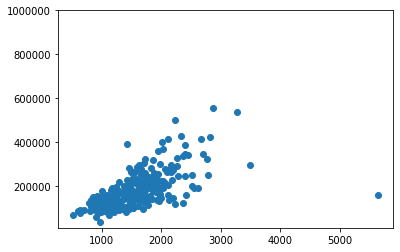

In [3]:
visualize_prices(validation)

### Plot price over time to try to figure out to what extent this is time series data

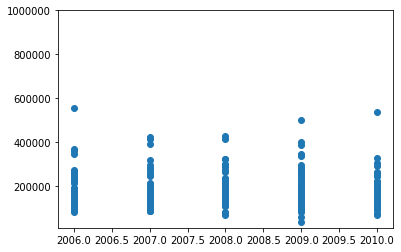

In [4]:
visualize_prices(validation,"YrSold")

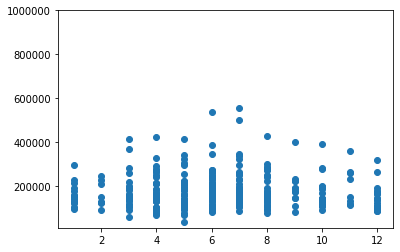

In [5]:
visualize_prices(validation,"MoSold")

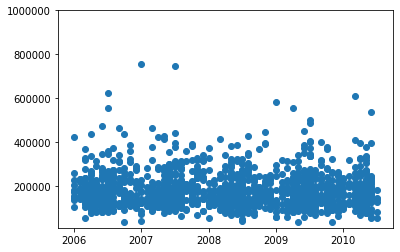

In [6]:
YrMoSold = train.loc[ : , "YrSold"] + ((train.loc[ : , "MoSold"] - 1) / 12)
plt.scatter(YrMoSold, train["SalePrice"])
plt.ylim(10000,1000000)
plt.show()

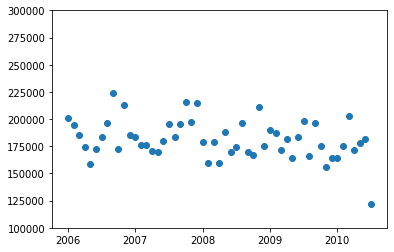

In [7]:
with_yr_mo = train.assign(YrMoSold=YrMoSold)
grouped_by_yr_mo = with_yr_mo.groupby('YrMoSold')
mean_sale_price = grouped_by_yr_mo.SalePrice.mean()
plt.scatter(mean_sale_price.index, mean_sale_price.values)
plt.ylim(100000,300000)
plt.show()

To my eye, there's no obvious huge temporal pattern

## For each predictor, plot predicted sale price by square footage. Also, show RMSE on validation for that predictor.

### Predict that each house in test will have sell for the median price of a house in train:

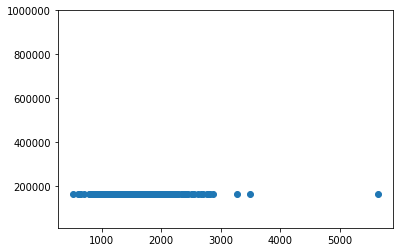

In [8]:
visualize_prices(predict_with_median(training, validation))

In [9]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_median)

0.402093925967283

### Single variable linear regression using lot area:

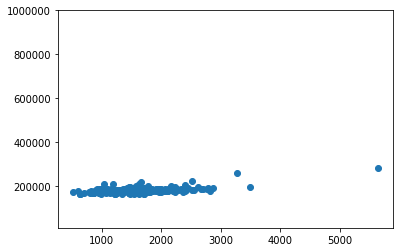

In [10]:
visualize_prices(predict_with_lot_area(training, validation))

In [11]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_lot_area)

0.3661731915890161

### Linear regression using naively all features that are expressed as numbers:

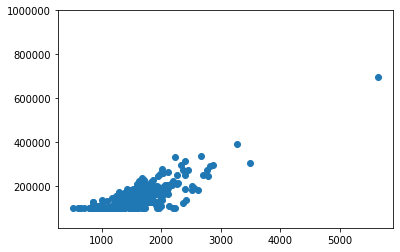

In [12]:
visualize_prices(predict_with_all_easy_linear(training, validation))

In [13]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_all_easy_linear)

0.2843056120822336

### Ridge regression -- a type of regularized linear regression: https://scikit-learn.org/stable/modules/linear_model.html

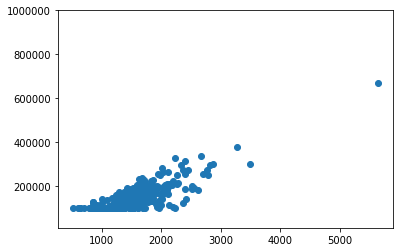

In [14]:
visualize_prices(predict_with_ridge(training, validation))

In [15]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_ridge)

0.34979595830483085

### Polynomial features + ridge regression

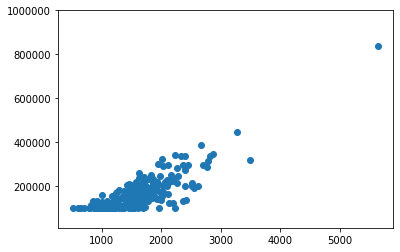

In [16]:
visualize_prices(predict_with_polynomial_features_and_ridge(training, validation, {"degree": 2, "clip": 100000, "scale": True}))

In [17]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_polynomial_features_and_ridge, {"degree": 2, "clip": 100000, "scale": True})

0.3152592993315705

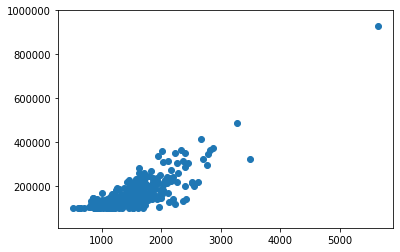

In [18]:
visualize_prices(predict_with_polynomial_features_and_ridge(training, validation, {"degree": 3, "clip": 100000, "scale": True}))

In [19]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_polynomial_features_and_ridge, {"degree": 3, "clip": 100000, "scale": True})

0.28601591711648083

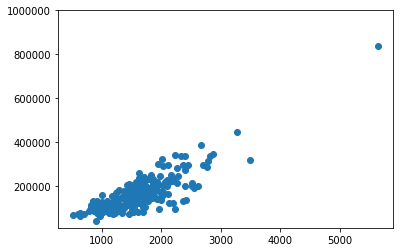

In [20]:
visualize_prices(predict_with_polynomial_features_and_ridge(training, validation, {"degree": 2, "clip": 10000, "scale": True}))

In [21]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_polynomial_features_and_ridge, {"degree": 2, "clip": 10000, "scale": True})

0.19530225657173644

## Why do more naive linear regressions seem to perform better?
### Scaling vs. no scaling

In [22]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_all_easy_linear, {"scale": False})

0.1682124252272107

In [23]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_all_easy_linear, {"scale": True})

0.3584144482877734

In [24]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_ridge, {"scale": False})

0.17245838057410892

In [25]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_ridge, {"scale": True})

0.3033359261988397

In [26]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_polynomial_features_and_ridge, {"degree": 2, "clip": 100000, "scale": False})

0.6369654052937251

In [27]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_polynomial_features_and_ridge, {"degree": 2, "clip": 100000, "scale": True})

0.20969344342195734

Interesting that whether scaling is better or worse depends on which linear predictor is used, I have some theories about why that'd be but don't really know why

## Original, easy set of numerical features vs. all features

In [28]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_all_easy_linear, {"features": all_numerical_features})

13.784969704246883

In [29]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_all_easy_linear, {"features": original_features})

0.2662097196635885

In [30]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_ridge, {"features": all_numerical_features})

0.2290301859387101

In [31]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_ridge, {"features": original_features})

0.31891811108148393

In [32]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_polynomial_features_and_ridge, {"degree": 2, "clip": 100000, "features": all_numerical_features})

0.21539923022438487

In [33]:
evalute_predictor("data_from_kaggle/train.csv", predict_with_polynomial_features_and_ridge, {"degree": 2, "clip": 100000, "features": original_features})

0.3321729038084982

Weird, original features only are universally better. Could be that:
- the interpolation is deeply fucking with things
- I'm adjusting too weakly for multiple x variables